# Multi-Extension FITS Processing with FitsBolt

This notebook demonstrates how to create and process multi-extension FITS files using the FitsBolt package. We'll:

1. Create 10 temporary FITS files with 4 extensions each
2. Read these files using `read_images`
3. Apply normalization with `normalize_images`
4. Resize the images with `resize_images`
5. Map the 4 extensions to 3 output channels (RGB) using different mapping strategies

This tutorial is particularly useful for astronomical data processing where different wavelengths or observation types are stored in separate extensions within a FITS file.

## 1. Import Required Libraries

First, let's import the necessary libraries for our demonstration:

In [2]:
# Standard libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from time import time
import tempfile
import shutil
from pathlib import Path

# Astropy for FITS handling
from astropy.io import fits

# Import fitsbolt modules
from fitsbolt.read import read_images, read_images
from fitsbolt.normalisation.normalisation import normalise_images
from fitsbolt.normalisation.NormalisationMethod import NormalisationMethod
from fitsbolt.resize import resize_image, resize_images

# For visualization
from matplotlib.colors import LogNorm
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)
plt.style.use('dark_background')  # Astronomy images often look better on dark backgrounds

In [3]:
# Helper function for displaying images
def display_images(images, titles=None, cmaps=None, figsize=(16, 8), rows=1):
    """Display multiple images side by side
    
    Args:
        images: List of image arrays to display
        titles: List of titles for each image
        cmaps: List of colormaps to use for each image (or single colormap for all)
        figsize: Figure size
        rows: Number of rows for the subplots
    """
    n = len(images)
    cols = (n + rows - 1) // rows
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    elif rows == 1 or cols == 1:
        axes = axes.flatten()
    
    if titles is None:
        titles = [f"Image {i+1}" for i in range(n)]
    
    if cmaps is None:
        cmaps = ['viridis'] * n
    elif isinstance(cmaps, str):
        cmaps = [cmaps] * n
        
    for i in range(n):
        if i < len(axes):
            if images[i].ndim == 3 and images[i].shape[2] == 3:
                # RGB image
                im = axes[i].imshow(images[i])
            else:
                # Grayscale image
                im = axes[i].imshow(images[i], cmap=cmaps[i])
            axes[i].set_title(titles[i])
            axes[i].axis('off')
            plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
    
    # Hide empty subplots
    for i in range(n, len(axes)):
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()

## 2. Create Temporary Multi-Extension FITS Files

Let's create 10 temporary FITS files, each with 4 extensions. These extensions will simulate different wavelength observations that we'll later map to RGB channels.

In [4]:
# Create a temporary directory for our FITS files
temp_dir = os.path.join(tempfile.gettempdir(), 'fitsbolt_demo')
if os.path.exists(temp_dir):
    shutil.rmtree(temp_dir)  # Clean up any previous runs
os.makedirs(temp_dir)
print(f"Created temporary directory: {temp_dir}")

# Function to create a multi-extension FITS file
def create_multi_extension_fits(filename, size=(256, 256), num_extensions=4):
    """
    Create a FITS file with multiple extensions for testing.
    
    Args:
        filename: Output filename
        size: Image size as (height, width)
        num_extensions: Number of extensions to create
    
    Returns:
        str: Path to the created file
    """
    # Create primary HDU (usually empty in FITS files)
    primary_hdu = fits.PrimaryHDU()
    
    # Add information to the primary header
    primary_hdu.header['OBSERVER'] = 'FitsBolt User'
    primary_hdu.header['OBJECT'] = f'Test Object {Path(filename).stem}'
    primary_hdu.header['DATE-OBS'] = '2025-07-29T00:00:00'
    
    # Create a list to hold all HDUs
    hdus = [primary_hdu]
    
    # Define extension names (common in astronomical data)
    extension_names = ['H_ALPHA', 'O_III', 'S_II', 'LUMINANCE']
    
    # Create data for each extension with different patterns
    center_y, center_x = size[0]//2, size[1]//2
    y, x = np.ogrid[:size[0], :size[1]]
    r = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    theta = np.arctan2(y - center_y, x - center_x)
    
    for i in range(num_extensions):
        # Create different patterns for each extension
        if i == 0:  # H-alpha (typically red in narrowband imaging)
            # Filamentary structure with spiral pattern
            data = np.exp(-(r/200)**2) * 1000 * (1 + 0.5*np.sin(theta*6 + r/20))
            data += np.random.normal(0, 10, size)
        elif i == 1:  # O-III (typically green/blue in narrowband imaging)
            # Bubble-like structure
            data = np.exp(-((r-80)/40)**2) * 1200
            data += np.random.normal(0, 12, size)
        elif i == 2:  # S-II (typically orange/red in narrowband imaging)
            # Clumpy structure
            data = np.zeros(size)
            for j in range(15):
                cx, cy = np.random.randint(0, size[0]), np.random.randint(0, size[1])
                cloud_r = np.sqrt((x - cx)**2 + (y - cy)**2)
                data += np.exp(-cloud_r/30) * np.random.uniform(800, 1200)
            data += np.random.normal(0, 8, size)
        else:  # Luminance (broadband)
            # Overall structure with more detail
            spiral = np.sin(r/15 - theta*3) + 1
            data = spiral * np.exp(-(r/250)**2) * 1500
            data += np.random.normal(0, 15, size)
        
        # Add some bright point sources (stars)
        stars = np.random.exponential(1, size) * (np.random.rand(*size) > 0.996) * 6000
        data += stars
        
        # Ensure no negative values
        data = np.clip(data, 0, None)
        
        # Create the image HDU
        image_hdu = fits.ImageHDU(data.astype(np.float32))
        
        # Set extension name
        if i < len(extension_names):
            image_hdu.header['EXTNAME'] = extension_names[i]
        else:
            image_hdu.header['EXTNAME'] = f'EXT{i+1}'
            
        # Add metadata specific to each extension
        image_hdu.header['FILTER'] = extension_names[i] if i < len(extension_names) else f'FILTER{i+1}'
        image_hdu.header['EXPTIME'] = np.random.uniform(100, 1000)  # Exposure time in seconds
        image_hdu.header['GAIN'] = np.random.uniform(1.0, 2.5)      # Detector gain
        
        # Add to HDU list
        hdus.append(image_hdu)
    
    # Create HDU list and write to file
    hdul = fits.HDUList(hdus)
    hdul.writeto(filename, overwrite=True)
    
    return filename

# Create 10 FITS files with 4 extensions each
fits_files = []
for i in range(10):
    filename = os.path.join(temp_dir, f"multi_ext_{i+1:02d}.fits")
    create_multi_extension_fits(filename, size=(256, 256), num_extensions=4)
    fits_files.append(filename)

print(f"Created {len(fits_files)} FITS files with 4 extensions each in '{temp_dir}'")

# Check the structure of the first file
with fits.open(fits_files[0]) as hdul:
    print(f"\nStructure of {os.path.basename(fits_files[0])}:")
    print(f"Number of HDUs: {len(hdul)}")
    for i, hdu in enumerate(hdul):
        if i == 0:
            print(f"  HDU {i}: Primary (no data)")
        else:
            print(f"  HDU {i}: {hdu.header.get('EXTNAME', f'Extension {i}')} - "
                  f"Shape: {hdu.data.shape}, Type: {hdu.data.dtype}")
            print(f"     FILTER: {hdu.header.get('FILTER', 'N/A')}, "
                  f"EXPTIME: {hdu.header.get('EXPTIME', 'N/A'):.1f}s")

Created temporary directory: C:\Users\laslo\AppData\Local\Temp\fitsbolt_demo
Created 10 FITS files with 4 extensions each in 'C:\Users\laslo\AppData\Local\Temp\fitsbolt_demo'

Structure of multi_ext_01.fits:
Number of HDUs: 5
  HDU 0: Primary (no data)
  HDU 1: H_ALPHA - Shape: (256, 256), Type: >f4
     FILTER: H_ALPHA, EXPTIME: 687.0s
  HDU 2: O_III - Shape: (256, 256), Type: >f4
     FILTER: O_III, EXPTIME: 454.3s
  HDU 3: S_II - Shape: (256, 256), Type: >f4
     FILTER: S_II, EXPTIME: 383.7s
  HDU 4: LUMINANCE - Shape: (256, 256), Type: >f4
     FILTER: LUMINANCE, EXPTIME: 239.0s
Created 10 FITS files with 4 extensions each in 'C:\Users\laslo\AppData\Local\Temp\fitsbolt_demo'

Structure of multi_ext_01.fits:
Number of HDUs: 5
  HDU 0: Primary (no data)
  HDU 1: H_ALPHA - Shape: (256, 256), Type: >f4
     FILTER: H_ALPHA, EXPTIME: 687.0s
  HDU 2: O_III - Shape: (256, 256), Type: >f4
     FILTER: O_III, EXPTIME: 454.3s
  HDU 3: S_II - Shape: (256, 256), Type: >f4
     FILTER: S_II, E

### 2.1 Visualize the Raw FITS Extensions

Let's examine the individual extensions of one of our FITS files to understand what data we'll be working with:

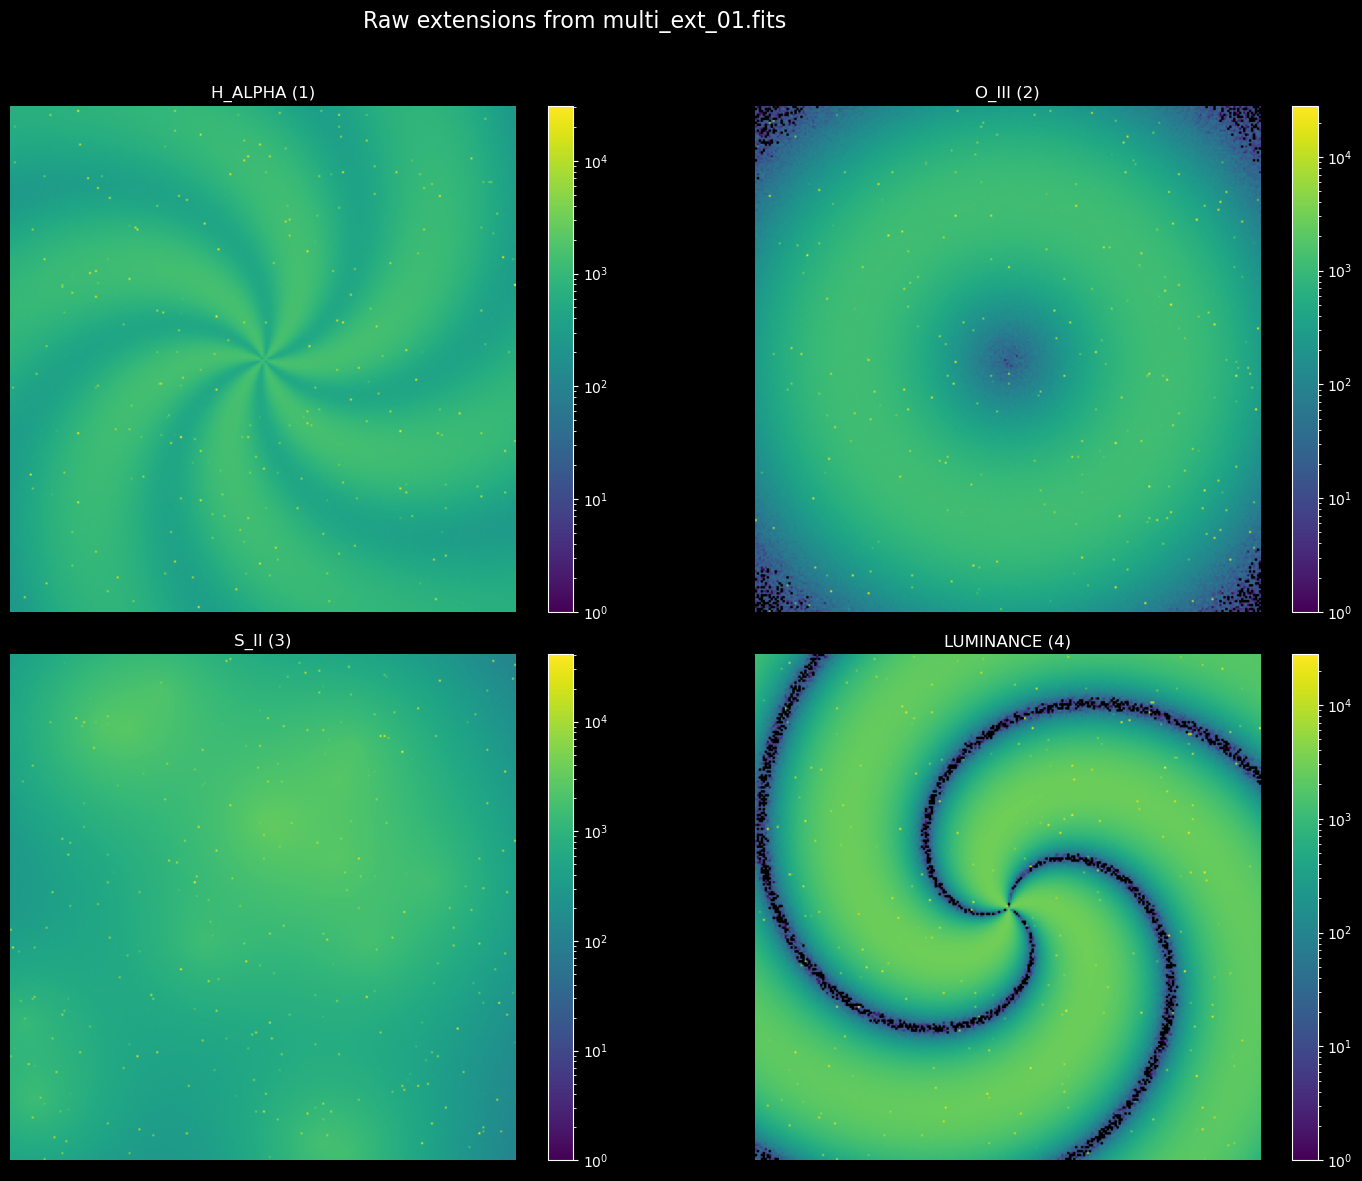

In [5]:
# Load the extensions individually using astropy.io.fits directly for visualization
sample_file = fits_files[0]

with fits.open(sample_file) as hdul:
    # Skip the primary HDU (index 0) which has no data
    extension_data = []
    extension_names = []
    
    for i in range(1, len(hdul)):
        ext = hdul[i]
        extension_data.append(ext.data)
        extension_names.append(f"{ext.header.get('EXTNAME', f'Extension {i}')} ({i})")
    
    # Visualize each extension
    plt.figure(figsize=(16, 12))
    for i, (data, name) in enumerate(zip(extension_data, extension_names)):
        plt.subplot(2, 2, i+1)
        
        # Use log normalization for better visibility of astronomical data
        im = plt.imshow(data, cmap='viridis', norm=LogNorm(vmin=1, vmax=data.max()))
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.title(name)
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(f"Raw extensions from {os.path.basename(sample_file)}", fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()

## 3. Reading Multi-Extension FITS Files with FitsBolt

Now that we have our test files, let's use FitsBolt to read them and map the extensions to RGB channels.

### 3.1 Basic Extension to RGB Mapping

We'll demonstrate three different approaches to mapping FITS extensions to RGB channels:

1. **Direct Mapping**: Map extensions 1, 2, 3 directly to R, G, B channels
2. **Custom Channel Combination**: Use a custom matrix to combine extensions
3. **Using a Single Extension**: Map extension 4 (Luminance) to all RGB channels for a grayscale image

2025-07-29 17:18:24.205 | INFO     | fitsbolt.cfg.create_config:validate_config:470 - Config: validation successful


Created channel_combination array with shape (3, 3)
Array contents: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


Reading images: 100%|██████████| 1/1 [00:00<00:00, 827.77it/s]

Direct mapping result shape: (256, 256, 3)
Data type: >f4
Value range: [0.0, 40879.6]


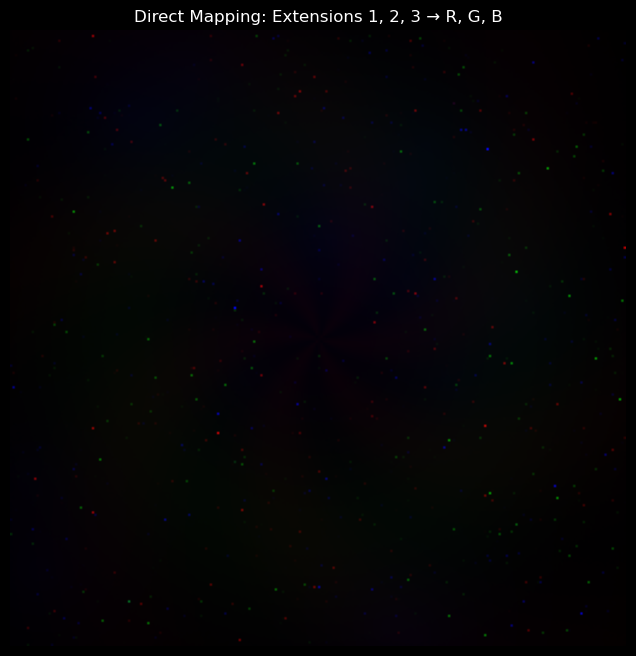

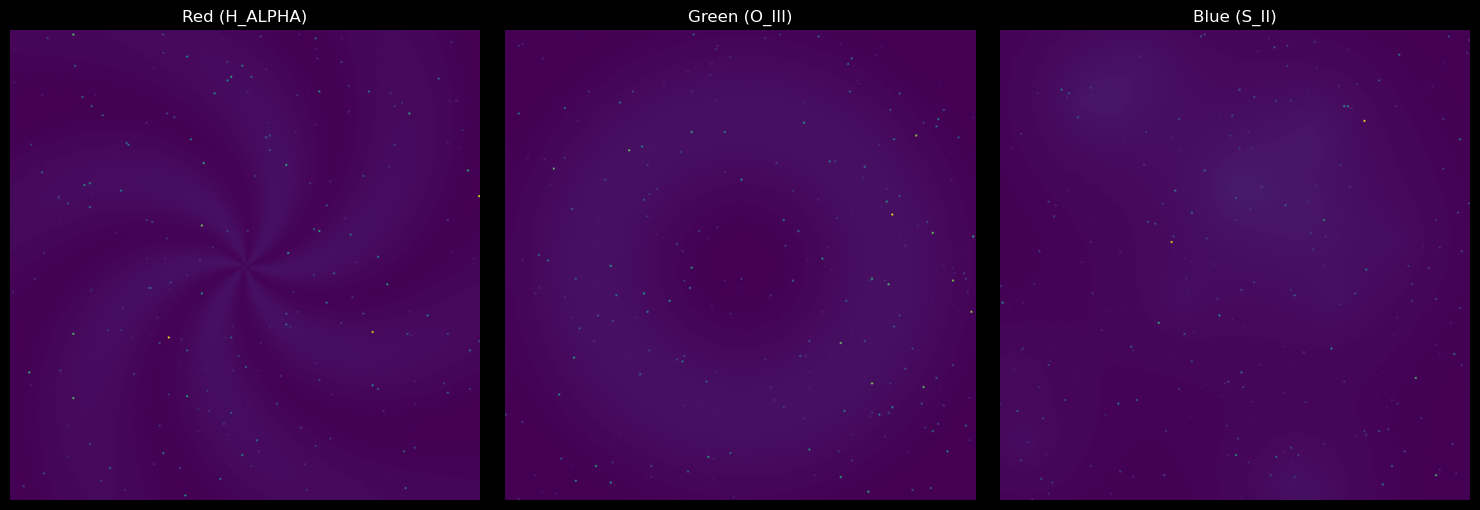

In [7]:
# Approach 1: Direct Mapping - Map extensions 1, 2, 3 to RGB channels
sample_file = fits_files[0]

# Use read_image with fits_extension parameter to specify which extensions to use
direct_mapped_image = read_images(
    sample_file,
    fits_extension=[1, 2, 3],  # H_ALPHA, O_III, S_II -> R, G, B
    n_output_channels=3       # We want RGB output
)

print(f"Direct mapping result shape: {direct_mapped_image.shape}")
print(f"Data type: {direct_mapped_image.dtype}")
print(f"Value range: [{direct_mapped_image.min():.1f}, {direct_mapped_image.max():.1f}]")

# Normalize for display purposes only
display_img = np.clip(direct_mapped_image / direct_mapped_image.max(), 0, 1)

plt.figure(figsize=(10, 8))
plt.imshow(display_img)
plt.title("Direct Mapping: Extensions 1, 2, 3 → R, G, B")
plt.axis('off')
plt.show()

# Display individual channels
plt.figure(figsize=(15, 5))
channel_names = ['Red (H_ALPHA)', 'Green (O_III)', 'Blue (S_II)']
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(direct_mapped_image[:,:,i], cmap='viridis')
    plt.title(channel_names[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

### 3.2 Custom Channel Combination

Now let's use a custom mapping matrix to combine the extensions. This allows for more sophisticated color mappings, such as:

- Red channel: 70% H-alpha + 30% S-II
- Green channel: 80% O-III + 20% Luminance
- Blue channel: 60% O-III + 40% S-II

This is similar to the "Hubble palette" used in astrophotography where different spectral lines are mapped to create scientifically informative but also visually appealing images.

In [ ]:
# Approach 2: Custom Channel Combination - Create a mapping matrix

# Define a custom mapping of extensions to RGB channels
# Each row represents an output channel (R, G, B)
# Each column represents a weight for the corresponding FITS extension (1, 2, 3, 4)
# In this example:
# R = 0.7*H_ALPHA (ext1) + 0.3*S_II (ext3)
# G = 0.8*O_III (ext2) + 0.2*LUMINANCE (ext4)
# B = 0.6*O_III (ext2) + 0.4*S_II (ext3)

channel_mapping =[[0.7, 0.0, 0.3, 0.0],  # R channel
     [0.0, 0.8, 0.0, 0.2],  # G channel
    [0.0, 0.6, 0.4, 0.0]]  # B channel

# Read with custom mapping
custom_mapped_image = read_images(
    sample_file,
    fits_extension=[1, 2, 3, 4],  # Use all extensions
    n_output_channels=3,          # We want RGB output
    channel_combination=channel_mapping  # Apply our custom mapping
)

print(f"Custom mapping result shape: {custom_mapped_image.shape}")
print(f"Data type: {custom_mapped_image.dtype}")
print(f"Value range: [{custom_mapped_image.min():.1f}, {custom_mapped_image.max():.1f}]")

# Normalize for display purposes only
display_img = np.clip(custom_mapped_image / custom_mapped_image.max(), 0, 1)

plt.figure(figsize=(10, 8))
plt.imshow(display_img)
plt.title("Custom Mapping:\nR = 0.7*H_ALPHA + 0.3*S_II\nG = 0.8*O_III + 0.2*LUMINANCE\nB = 0.6*O_III + 0.4*S_II")
plt.axis('off')
plt.show()

# Display individual channels
plt.figure(figsize=(15, 5))
channel_names = ['Red Channel', 'Green Channel', 'Blue Channel']
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(custom_mapped_image[:,:,i], cmap='viridis')
    plt.title(channel_names[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

AttributeError: 'dict' object has no attribute 'shape'

### 3.3 Single Extension Mapping

For our third approach, we'll map a single extension (the Luminance channel) to all three RGB channels to create a grayscale image with RGB structure.

In [ ]:
# Approach 3: Single Extension to all channels
# Map extension 4 (Luminance) to all RGB channels for a grayscale image

luminance_image = read_image(
    sample_file,
    fits_extension=4,     # Use only the Luminance extension
    n_output_channels=3   # Still create RGB structure
)

print(f"Luminance mapping result shape: {luminance_image.shape}")
print(f"Data type: {luminance_image.dtype}")
print(f"Value range: [{luminance_image.min():.1f}, {luminance_image.max():.1f}]")

# Normalize for display
display_img = np.clip(luminance_image / luminance_image.max(), 0, 1)

plt.figure(figsize=(10, 8))
plt.imshow(display_img, cmap='gray')
plt.title("Luminance Only (Extension 4)")
plt.axis('off')
plt.show()

# Compare all three approaches
plt.figure(figsize=(16, 5))
titles = [
    "Direct: Exts 1,2,3 → RGB", 
    "Custom Channel Combination", 
    "Luminance Only"
]

# Normalize each image for display
imgs = [direct_mapped_image, custom_mapped_image, luminance_image]
norm_imgs = [np.clip(img / img.max(), 0, 1) for img in imgs]

for i, (img, title) in enumerate(zip(norm_imgs, titles)):
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

## 4. Normalizing Multi-Extension Images

Astronomical images often have high dynamic range and need to be normalized. Let's apply different normalization methods to our custom-mapped image.

In [ ]:
# We'll use our custom-mapped image and apply different normalization methods
input_image = custom_mapped_image

# Apply different normalization methods
norm_images = []
norm_titles = []

# 1. CONVERSION_ONLY - Simple linear stretch
norm_conversion = normalize_image(
    input_image, 
    normalisation_method=NormalisationMethod.CONVERSION_ONLY,
    output_dtype=np.uint8
)
norm_images.append(norm_conversion)
norm_titles.append("CONVERSION_ONLY")

# 2. LOG stretch - Good for high dynamic range data
norm_log = normalize_image(
    input_image, 
    normalisation_method=NormalisationMethod.LOG,
    output_dtype=np.uint8
)
norm_images.append(norm_log)
norm_titles.append("LOG Stretch")

# 3. ZSCALE - Common in astronomy visualization
norm_zscale = normalize_image(
    input_image, 
    normalisation_method=NormalisationMethod.ZSCALE,
    output_dtype=np.uint8
)
norm_images.append(norm_zscale)
norm_titles.append("ZSCALE")

# 4. ASINH - Best for preserving both bright and faint details
norm_asinh = normalize_image(
    input_image, 
    normalisation_method=NormalisationMethod.ASINH,
    norm_asinh_scale=[0.7, 0.7, 0.7],    # Stretch factor per channel
    norm_asinh_clip=[99.5, 99.5, 99.5],  # Percentile clipping per channel
    output_dtype=np.uint8
)
norm_images.append(norm_asinh)
norm_titles.append("ASINH Stretch")

# Display all normalized images for comparison
plt.figure(figsize=(15, 10))
for i, (img, title) in enumerate(zip(norm_images, norm_titles)):
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Choose the ASINH normalization for further processing
normalized_image = norm_asinh
print(f"Normalized image shape: {normalized_image.shape}")
print(f"Data type: {normalized_image.dtype}")
print(f"Value range: [{normalized_image.min()}, {normalized_image.max()}]")

## 5. Resizing Images

Now let's resize our normalized image to different dimensions using different interpolation methods.

In [ ]:
# Let's resize to different sizes with different interpolation methods
input_image = normalized_image

# Resize to different sizes
target_sizes = [(128, 128), (64, 64), (512, 512)]
resized_images = []
resized_titles = []

for size in target_sizes:
    # Use default bilinear interpolation (order=1)
    resized = resize_image(
        input_image, 
        size=size, 
        output_dtype=np.uint8
    )
    resized_images.append(resized)
    resized_titles.append(f"{size[0]}x{size[1]}")
    print(f"Resized to {size}, shape: {resized.shape}")

# Display resized images
plt.figure(figsize=(15, 5))
for i, (img, title) in enumerate(zip(resized_images, resized_titles)):
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Try different interpolation methods for one size
size = (128, 128)
interpolation_orders = [0, 1, 3, 5]  # 0=nearest, 1=bilinear, 3=cubic, 5=quintic
interp_images = []
interp_titles = []

for order in interpolation_orders:
    resized = resize_image(
        input_image, 
        size=size, 
        interpolation_order=order,
        output_dtype=np.uint8
    )
    interp_images.append(resized)
    interp_titles.append(f"Order {order}")

# Display resized images with different interpolation orders
plt.figure(figsize=(15, 5))
for i, (img, title) in enumerate(zip(interp_images, interp_titles)):
    plt.subplot(1, 4, i+1)
    plt.imshow(img)
    plt.title(f"Size {size}, {title}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Choose a final resized image for further processing
resized_image = resized_images[2]  # 512x512 version
print(f"Final resized image shape: {resized_image.shape}")
print(f"Data type: {resized_image.dtype}")

## 6. Batch Processing with FitsBolt

Now let's process all of our 10 FITS files in parallel using FitsBolt's batch processing capabilities.

In [ ]:
# Process all FITS files using the custom mapping approach
# Define the mapping that we'll use for all files
channel_mapping = {
    0: [0.7, 0.0, 0.3, 0.0],  # R channel
    1: [0.0, 0.8, 0.0, 0.2],  # G channel
    2: [0.0, 0.6, 0.4, 0.0]   # B channel
}

# Step 1: Read all FITS files with our mapping
print(f"Processing {len(fits_files)} FITS files...")
start_time = time()

# Read multiple files with extension mapping
rgb_images = read_images(
    fits_files,
    fits_extension=[1, 2, 3, 4],  # Use all data extensions
    n_output_channels=3,          # We want RGB output
    channel_combination=channel_mapping,
    num_workers=4,                # Use parallel processing
    show_progress=True
)

read_time = time() - start_time
print(f"Read {len(rgb_images)} multi-extension images in {read_time:.2f} seconds")

# Step 2: Normalize all images
start_time = time()
norm_images = normalize_images(
    rgb_images,
    normalisation_method=NormalisationMethod.ASINH,
    norm_asinh_scale=[0.7, 0.7, 0.7],
    norm_asinh_clip=[99.5, 99.5, 99.5],
    output_dtype=np.uint8,
    num_workers=4,
    show_progress=True
)

norm_time = time() - start_time
print(f"Normalized {len(norm_images)} images in {norm_time:.2f} seconds")

# Step 3: Resize all normalized images
target_size = (128, 128)
start_time = time()
resized_images = resize_images(
    norm_images,
    size=target_size,
    interpolation_order=1,
    output_dtype=np.uint8,
    num_workers=4,
    show_progress=True
)

resize_time = time() - start_time
print(f"Resized {len(resized_images)} images to {target_size} in {resize_time:.2f} seconds")
print(f"Total processing time: {read_time + norm_time + resize_time:.2f} seconds")

# Display a sample of the results
num_samples = min(5, len(resized_images))
plt.figure(figsize=(15, 3*num_samples))

for i in range(num_samples):
    plt.subplot(num_samples, 1, i+1)
    plt.imshow(resized_images[i])
    plt.title(f"Processed Image {i+1}: {os.path.basename(fits_files[i])}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

## 7. Cleanup and Conclusion

Let's clean up our temporary files and summarize what we've learned.

In [ ]:
# Clean up temporary files
try:
    shutil.rmtree(temp_dir)
    print(f"Cleaned up temporary directory: {temp_dir}")
except Exception as e:
    print(f"Error cleaning up temporary directory: {e}")

### Summary

In this tutorial, we've demonstrated the powerful capabilities of FitsBolt for processing multi-extension FITS files, particularly focusing on:

1. **Creating test FITS files** with multiple extensions (4 per file)
2. **Reading extensions** using different mapping strategies:
   - Direct mapping of extensions to RGB channels
   - Custom channel combination with weight matrices
   - Single extension mapping to all channels
3. **Normalizing images** with various methods:
   - CONVERSION_ONLY (linear stretch)
   - LOG (logarithmic stretch)
   - ZSCALE (Z-scale algorithm)
   - ASINH (inverse hyperbolic sine stretch)
4. **Resizing images** with different:
   - Target sizes
   - Interpolation methods
5. **Batch processing** multiple files in parallel for efficiency

This workflow is particularly useful for astronomical data processing where different observations or wavelengths are stored in separate FITS extensions and need to be combined in scientifically meaningful and visually appealing ways.

The ability to map 4 extensions to 3 output channels with custom weighting provides tremendous flexibility for creating color images from scientific data.